# Eye of the Emergency

## Libraries and dataset import

In [1]:
# Data import & Exploring
import pandas as pd
#import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import seaborn as sns

# Text Processing
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import string

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import Booster

#Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

In [2]:
train_df = pd.read_csv('train_tweets.csv')
test_df = pd.read_csv('test_tweets.csv')

## Data Preprocess

In [3]:
unique_count = pd.DataFrame(pd.value_counts(train_df.text))
unique_count = unique_count.reset_index()
unique_count.columns = ['text', 'count']

In [4]:
unique_count.head()

,text,count
0,11-Year-Old Boy Charged With Manslaughter of T...,10
1,He came to a land which was engulfed in tribal...,6
2,The Prophet (peace be upon him) said 'Save you...,6
3,#Bestnaijamade: 16yr old PKK suicide bomber wh...,6
4,Madhya Pradesh Train Derailment: Village Youth...,5


In [5]:
train_df_unique = pd.DataFrame(train_df.text.unique(), columns = ['text'])

In [6]:
train_df_unique.head()

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...


In [7]:
train_df_unique = train_df_unique.merge(unique_count)

In [8]:
train_df_unique.head()

,text,count
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train_df_count = train_df.merge(unique_count)

In [10]:
train_df_count.head()

,id,keyword,location,text,target,count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1


In [11]:
lg = pd.DataFrame([len(txt) for txt in train_df.text], columns = ['len_text'])

In [12]:
lg.head()

,len_text
0,69
1,38
2,133
3,65
4,88


In [13]:
train_df_len = pd.concat([train_df_count, lg], axis = 1)

In [14]:
train_df_len.head()

,id,keyword,location,text,target,count,len_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,88


### Location Encoder

In [15]:
encode_location = pd.DataFrame([int(type(ct)==str) for ct in train_df_len.location], columns=['location_enc'])

In [16]:
encode_location.head()

,location_enc
0,0
1,0
2,0
3,0
4,0


In [17]:
train_df_location = pd.concat([train_df_len, encode_location], axis=1)

In [18]:
train_df_location.head()

,id,keyword,location,text,target,count,len_text,location_enc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,69,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,38,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,133,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,65,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,88,0


## NLTK

In [19]:
df = train_df_location.copy()

In [20]:
# text cleaning

def text_processing(text):
     #Charger les stop-words en anglais
    stop_words = set(stopwords.words('english'))

    # Initialiser le lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Appliquer la tokenisation à tous les textes
    tokens = word_tokenize(text.lower())

    # Supprimer les ponctuations
    tokens = [word for word in tokens if word not in string.punctuation]
    

    # Supprimer les stop-words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Supprimer les stop-words BIS
    tokens = [word for word in tokens if word[0:4] != "http"]
    tokens = [word for word in tokens if word[0:7] != "//t.co/"]
    

    # Appliquer la lemmatisation à tous les tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    
    # Supprimer les stop-words après lemmatisation
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [word for word in tokens if word[0] != "'"]
    tokens = [word for word in tokens if word != "n't"]
    tokens = [word for word in tokens if word != "amp"]
    tokens = [word for word in tokens if word != "new"]
    tokens = [word for word in tokens if word != "one"]
    tokens = [word for word in tokens if word != "like"]
    tokens = [word for word in tokens if word != "get"]
    tokens = [word for word in tokens if word != "would"]
    
    tokens = [word for word in tokens if word[0:len("\x89")] != "\x89"]
    tokens = [word for word in tokens if word[0:len("û_")] != "û_"]
    tokens = [word for word in tokens if word[0:len("û")] != "û"]
    
    tokens = ' '.join(tokens)
    
    return tokens
    

# Charger l'ensemble de données
#df = pd.read_csv('votre_fichier.csv')

In [21]:
# Appliquer la fonction Cleanup à tous les textes dans la colonne "text"
df['text_process'] = df['text'].apply(text_processing)

In [22]:
#df

In [23]:
text_process = [txt for txt in df.text_process]
text_process_0 = [txt for txt in df.text_process[df.target == 0]]
text_process_1 = [txt for txt in df.text_process[df.target == 1]]

In [24]:
#text_process

In [25]:
my_lst_str = ' '.join(map(str, text_process))
my_lst_str_0 = ' '.join(map(str, text_process_0))
my_lst_str_1 = ' '.join(map(str, text_process_1))

In [26]:
#my_lst_str

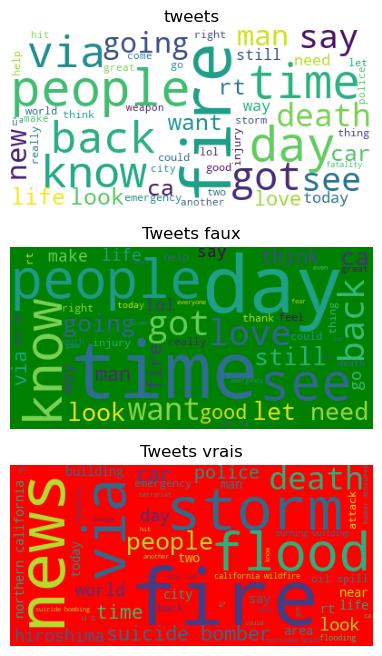

In [27]:
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)

wordcloud = WordCloud(background_color = 'white', stopwords = ["Û_"], max_words = 50).generate(my_lst_str)
plt.imshow(wordcloud)

plt.title('tweets')
plt.axis("off")

plt.subplot(3, 1, 2)

wordcloud_0 = WordCloud(background_color = 'green', stopwords = ["Û_"], max_words = 50).generate(my_lst_str_0)
plt.imshow(wordcloud_0)

plt.title('Tweets faux')
plt.axis("off")


plt.subplot(3, 1, 3)

wordcloud_1 = WordCloud(background_color = 'red', stopwords = ["Û_"], max_words = 50).generate(my_lst_str_1)
plt.imshow(wordcloud_1)

plt.title('Tweets vrais')
plt.axis("off")

plt.show()

## ML : Word Embedding - SKLEARN

In [28]:
X = df['text_process']

In [29]:
#vectorizer = CountVectorizer()
#X_vec = vectorizer.fit_transform(X)

In [30]:
tfidf = TfidfVectorizer()

In [31]:
X_vec = tfidf.fit_transform(X)

In [32]:
#feature_names = tfidf.get_feature_names()
#for col in X_vec.nonzero()[1]:
    #print (feature_names[col], ' - ', X_vec[0, col])

## ML : Dataset Split

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_vec, df['target'], test_size=0.2, random_state=42)


## ML : SVM avec sklearn

In [34]:
#instanciation
model_1 = SVC()

## ML : Decision Tree

In [35]:
#instanciation
model_2 = DecisionTreeClassifier(max_depth = 100, random_state =0)

## ML : Random Forest

In [36]:
#instanciation
model_3 = RandomForestClassifier(max_depth = 100)

## ML : SKL Log Reg

In [37]:
#instanciation
model_4 = LogisticRegression()

## ML : xgboost

The data is stored in a DMatrix object.

In [38]:
# Create regression matrices
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

In [39]:
#instanciation
model_5 = xgb.train({'objective': 'binary:logistic', 'eval_metric': 'auc'}, dtrain, num_boost_round=10)

## Train Models

In [40]:
for model in (model_1, model_2, model_3, model_4):
    model.fit(X_train, y_train)

In [41]:
print("SCORES")
for model in (model_1, model_2, model_3, model_4):
    print(model.__class__.__name__, ":", (round(model.score(X_val, y_val) * 100, 1)))

SCORES
SVC : 80.9
DecisionTreeClassifier : 75.2
RandomForestClassifier : 77.9
LogisticRegression : 81.5


In [42]:
y_pred_total = []

for model in (model_1, model_2, model_3, model_4, model_5):
    if model.__class__.__name__ == "Booster":
        y_pred = [round(pred) for pred in model.predict(dval)]
        
    else:
        y_pred = model.predict(X_val)
    
    y_pred_total.append(y_pred)
    
    acc_score = round( accuracy_score(y_val, y_pred) * 100, 1)
    prec_score = round( precision_score(y_val, y_pred) * 100, 1)
    rec_score = round( recall_score(y_val, y_pred) * 100, 1)
    f_score = round( f1_score (y_val, y_pred) * 100, 1)
    #print( model.__class__.__name__, acc_score, prec_score, rec_score, f_score)
    
    
    print( model.__class__.__name__)
    print('Accuracy : {} | Precision : {} | Recall : {} | F1 : {}'.format(acc_score, prec_score, rec_score, f_score))
    print()
    print('--------------------------------------------------------------')

SVC
Accuracy : 80.9 | Precision : 88.4 | Recall : 63.9 | F1 : 74.2

--------------------------------------------------------------
DecisionTreeClassifier
Accuracy : 75.2 | Precision : 74.2 | Recall : 64.7 | F1 : 69.1

--------------------------------------------------------------
RandomForestClassifier
Accuracy : 77.9 | Precision : 85.5 | Recall : 58.4 | F1 : 69.4

--------------------------------------------------------------
LogisticRegression
Accuracy : 81.5 | Precision : 86.8 | Recall : 67.1 | F1 : 75.7

--------------------------------------------------------------
Booster
Accuracy : 71.8 | Precision : 84.1 | Recall : 42.2 | F1 : 56.2

--------------------------------------------------------------


In [43]:
y_pred4 = model_4.predict(X_val)
clf_report = classification_report(y_val, y_pred4)

In [44]:
print(clf_report)

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       869
           1       0.87      0.67      0.76       654

    accuracy                           0.81      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523



In [45]:
print('--------------------------------------------------------------')    
i=-1
for model in (model_1, model_2, model_3, model_4, model_5):
    i = i + 1
    
    clf_report = classification_report(y_val, y_pred_total[i])
    
    print( model.__class__.__name__)
    print('--------------------------------------------------------------')
    print(clf_report)
    print()
    print('--------------------------------------------------------------')

--------------------------------------------------------------
SVC
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       869
           1       0.88      0.64      0.74       654

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.80      1523
weighted avg       0.82      0.81      0.80      1523


--------------------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       869
           1       0.74      0.65      0.69       654

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523


--------------------------------------------------------------
Ra

In [46]:
cnf_matrix = confusion_matrix(y_val, y_pred4)

In [47]:
#cnf_matrix

Text(50.722222222222214, 0.5, 'True')

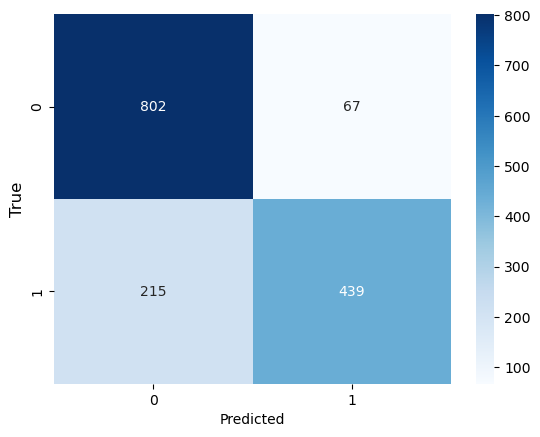

In [48]:
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)

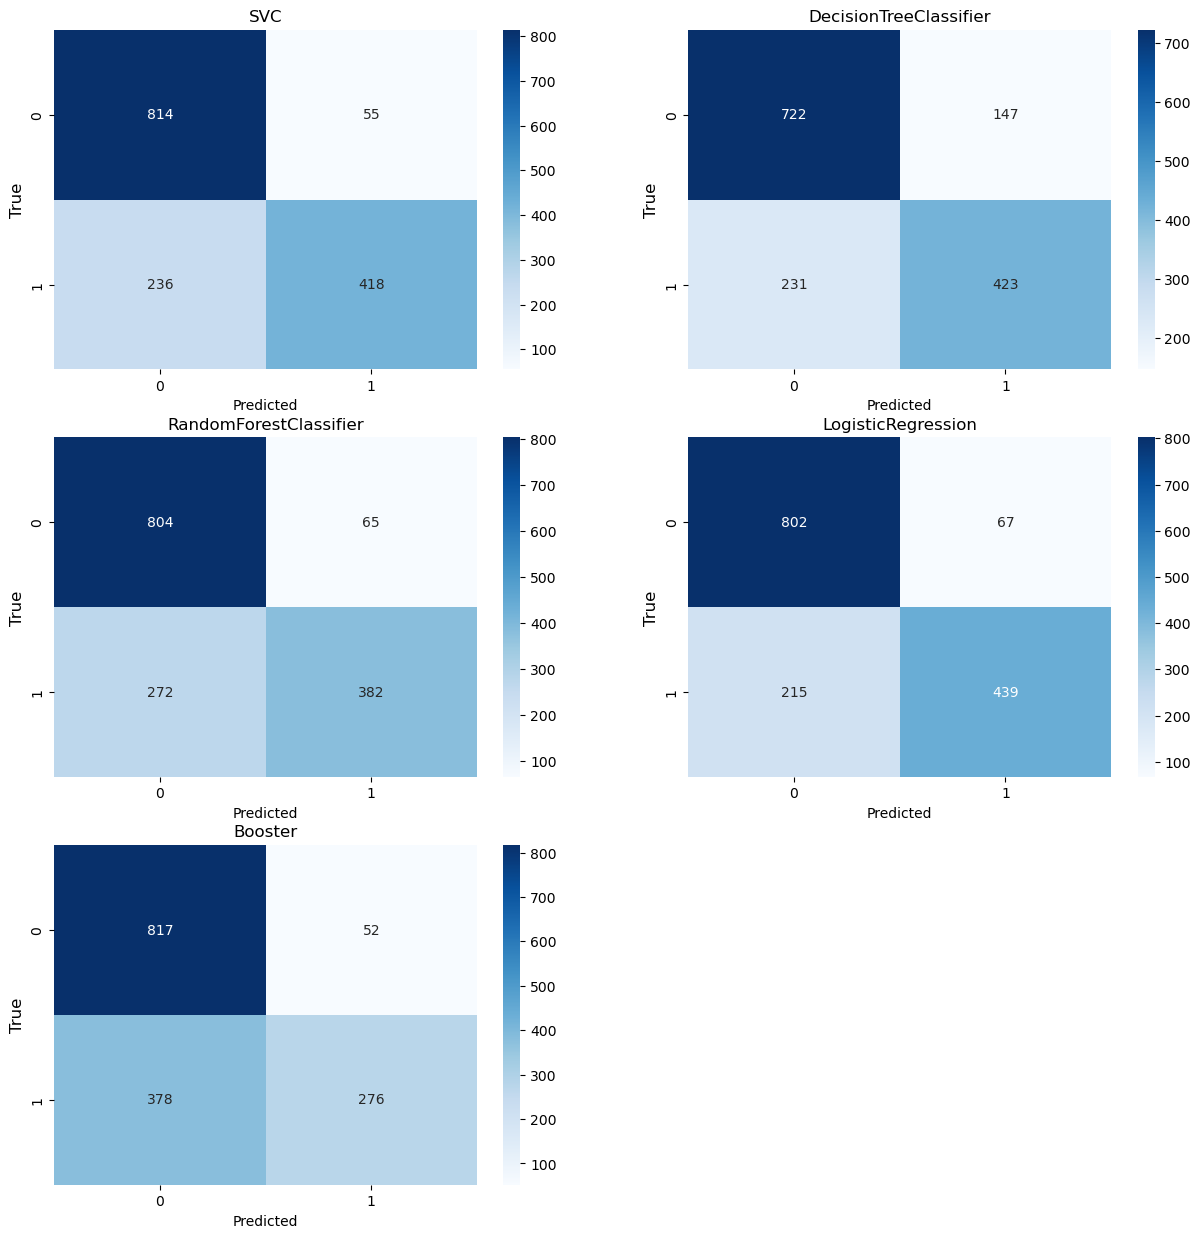

In [49]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)

cnf_matrix = confusion_matrix(y_val, y_pred_total[0])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_1.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 2)

cnf_matrix = confusion_matrix(y_val, y_pred_total[1])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_2.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 3)

cnf_matrix = confusion_matrix(y_val, y_pred_total[2])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_3.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 4)

cnf_matrix = confusion_matrix(y_val, y_pred_total[3])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_4.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 5)

cnf_matrix = confusion_matrix(y_val, y_pred_total[4])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_5.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")

plt.show()

## Prédiction -  TEST

In [50]:
def test(model, tweet):
    tw = []
    tw.append(tweet)
    #Prédiction
    X = pd.Series([tweet])
    X = tfidf.transform(X)
    
    if model.__class__.__name__ == "Booster":
        X = xgb.DMatrix(X)
        
    pred = model.predict(X)

    #affichage des résultats
    resultat = "Résultat (" + model.__class__.__name__ + "): "
    if pred[0] < 0.5:
        resultat = resultat + "NO DISASTER"
    if pred[0] >= 0.5:
        resultat = resultat + "DISASTER"
        
    return resultat

In [51]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "Help me, my house is on fire and all the forest is burning"))

Résultat (SVC): DISASTER
Résultat (DecisionTreeClassifier): DISASTER
Résultat (RandomForestClassifier): DISASTER
Résultat (LogisticRegression): DISASTER
Résultat (Booster): DISASTER


In [52]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "forest love"))

Résultat (SVC): NO DISASTER
Résultat (DecisionTreeClassifier): NO DISASTER
Résultat (RandomForestClassifier): NO DISASTER
Résultat (LogisticRegression): NO DISASTER
Résultat (Booster): NO DISASTER


In [53]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "beautiful forest"))

Résultat (SVC): NO DISASTER
Résultat (DecisionTreeClassifier): NO DISASTER
Résultat (RandomForestClassifier): NO DISASTER
Résultat (LogisticRegression): NO DISASTER
Résultat (Booster): NO DISASTER


In [54]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "the floor is on fire i love disco"))

Résultat (SVC): NO DISASTER
Résultat (DecisionTreeClassifier): DISASTER
Résultat (RandomForestClassifier): NO DISASTER
Résultat (LogisticRegression): NO DISASTER
Résultat (Booster): NO DISASTER


## Prédiction -  TEST

In [55]:
df_test = test_df.copy()

In [56]:
df_test['text_process'] = df_test['text'].apply(text_processing)

In [57]:
X_test = df_test['text_process']

In [58]:
X_test_vec = tfidf.transform(X_test)

In [59]:
test_total = []
X_test_db = xgb.DMatrix(X_test_vec)

for model in (model_1, model_2, model_3, model_4, model_5):
        
    if model.__class__.__name__ == "Booster":
        
        y_pred_test = model.predict(X_test_db)
        y_pred_test = [round(ypred) for ypred in y_pred_test]
        
    else:
    
        y_pred_test = model.predict(X_test_vec)
    
    test_total.append(y_pred_test)

In [60]:
test_total_df = pd.DataFrame(test_total).T

In [61]:
test_total_df.columns=[model.__class__.__name__ for model in [model_1, model_2, model_3, model_4, model_5]]

In [62]:
test_total_df.mean()

SVC                       0.312902
DecisionTreeClassifier    0.355195
RandomForestClassifier    0.282562
LogisticRegression        0.326693
Booster                   0.199203
dtype: float64

In [63]:
test_total_df.std()

SVC                       0.463746
DecisionTreeClassifier    0.478646
RandomForestClassifier    0.450314
LogisticRegression        0.469076
Booster                   0.399462
dtype: float64

In [66]:
test_total_df

,SVC,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,Booster
0,1,0,0,1,0
1,1,1,1,1,0
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
...,...,...,...,...,...
3258,1,1,1,1,0
3259,1,1,1,1,1
3260,1,1,1,1,0
3261,1,1,1,1,0


## SKL Log Reg : ROC CURVE

In [64]:
roc_auc = roc_auc_score(y_val, model_4.predict(X_val))

fpr, tpr, thresholds = roc_curve(y_val, model_4.predict_proba(X_val)[:,1])

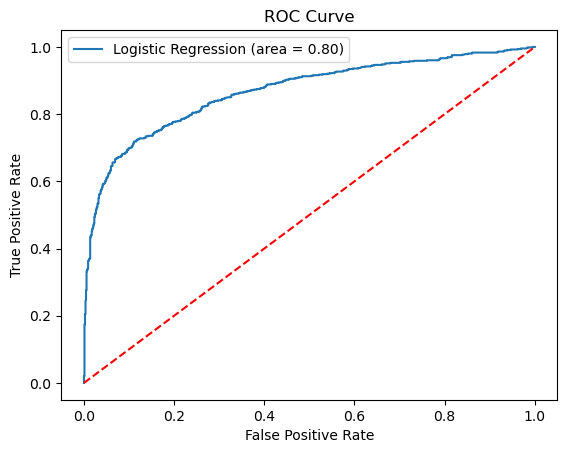

In [65]:
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()